# Import Libraries
---

In [160]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pylab

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

#Buat subplot
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
from pandas import Timestamp

# II. Data Loading
---

In [161]:
df = pd.read_csv('./data_for_modelling.csv')

df.head()

,date,status,fulfilment,sales_channel,ship_service_level,category,size,amazon_standard_id,qty,currency,sales,clean_ship_state,promotion_used
0,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,kurta,XL,B07WV4JV4D,1,INR,329.0,Maharashtra,True
1,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,Top,3XL,B098714BZP,1,INR,574.0,Tamil Nadu,False
2,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,Set,XL,B08YN7XDSG,1,INR,824.0,Uttar Pradesh,True
3,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,Set,L,B08CMHNWBN,1,INR,653.0,Chandigarh,True
4,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,kurta,XXL,B08B3XF5MH,1,INR,363.0,Tamil Nadu,False


In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77785 entries, 0 to 77784
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                77785 non-null  object 
 1   status              77785 non-null  object 
 2   fulfilment          77785 non-null  object 
 3   sales_channel       77785 non-null  object 
 4   ship_service_level  77785 non-null  object 
 5   category            77785 non-null  object 
 6   size                77785 non-null  object 
 7   amazon_standard_id  77785 non-null  object 
 8   qty                 77785 non-null  int64  
 9   currency            77785 non-null  object 
 10  sales               77785 non-null  float64
 11  clean_ship_state    77785 non-null  object 
 12  promotion_used      77785 non-null  bool   
dtypes: bool(1), float64(1), int64(1), object(10)
memory usage: 7.2+ MB


In [163]:
df['date'] = pd.to_datetime(df['date'])

In [164]:
df = df.sort_values(by='date')

df.tail()

,date,status,fulfilment,sales_channel,ship_service_level,category,size,amazon_standard_id,qty,currency,sales,clean_ship_state,promotion_used
54126,2022-06-29,Shipped,Amazon,Amazon.in,Expedited,kurta,S,B08B3YB5D1,1,INR,499.0,Tamil Nadu,True
54125,2022-06-29,Shipped,Amazon,Amazon.in,Expedited,kurta,6XL,B09LD24932,1,INR,925.0,West Bengal,True
54124,2022-06-29,Shipped,Amazon,Amazon.in,Expedited,kurta,XL,B0793RFRD2,1,INR,699.0,Karnataka,True
54132,2022-06-29,Shipped,Amazon,Amazon.in,Expedited,Western Dress,M,B0983292DV,1,INR,908.0,Andhra Pradesh,False
54182,2022-06-29,Shipped,Amazon,Amazon.in,Expedited,Western Dress,XXL,B0982YZ51B,1,INR,690.0,Tamil Nadu,False


In [165]:
df['sales'].isnull().sum()

0

In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77785 entries, 28882 to 54182
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                77785 non-null  datetime64[ns]
 1   status              77785 non-null  object        
 2   fulfilment          77785 non-null  object        
 3   sales_channel       77785 non-null  object        
 4   ship_service_level  77785 non-null  object        
 5   category            77785 non-null  object        
 6   size                77785 non-null  object        
 7   amazon_standard_id  77785 non-null  object        
 8   qty                 77785 non-null  int64         
 9   currency            77785 non-null  object        
 10  sales               77785 non-null  float64       
 11  clean_ship_state    77785 non-null  object        
 12  promotion_used      77785 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1),

In [167]:
df1 = df.groupby('date').agg(
    sales=('sales', 'sum'), # units sold is aggregated by summing
    qty=('qty', 'sum') # price is aggregated by averaging
).reset_index().sort_values('date')

In [168]:
df1

,date,sales,qty
0,2022-03-31,84574.0,135
1,2022-04-01,623454.0,974
2,2022-04-02,657308.0,1044
3,2022-04-03,726738.0,1116
4,2022-04-04,621870.0,952
...,...,...,...
86,2022-06-25,458603.0,681
87,2022-06-26,511759.0,759
88,2022-06-27,447699.0,660
89,2022-06-28,444275.0,669


In [169]:
df1 = df1.set_index('date')

In [170]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 91 entries, 2022-03-31 to 2022-06-29
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   91 non-null     float64
 1   qty     91 non-null     int64  
dtypes: float64(1), int64(1)
memory usage: 2.1 KB


In [171]:
# Mengetahui frekuensi dari Day index
freq = pd.infer_freq(df1.index)
print(freq)

D


# III. Data Overview
---

In [172]:
# Plot data menggunakan plotly
fig = px.line(df1, x=df1.index, y="sales", title='Sales Overtime')
fig.show()

## Decomposing
---

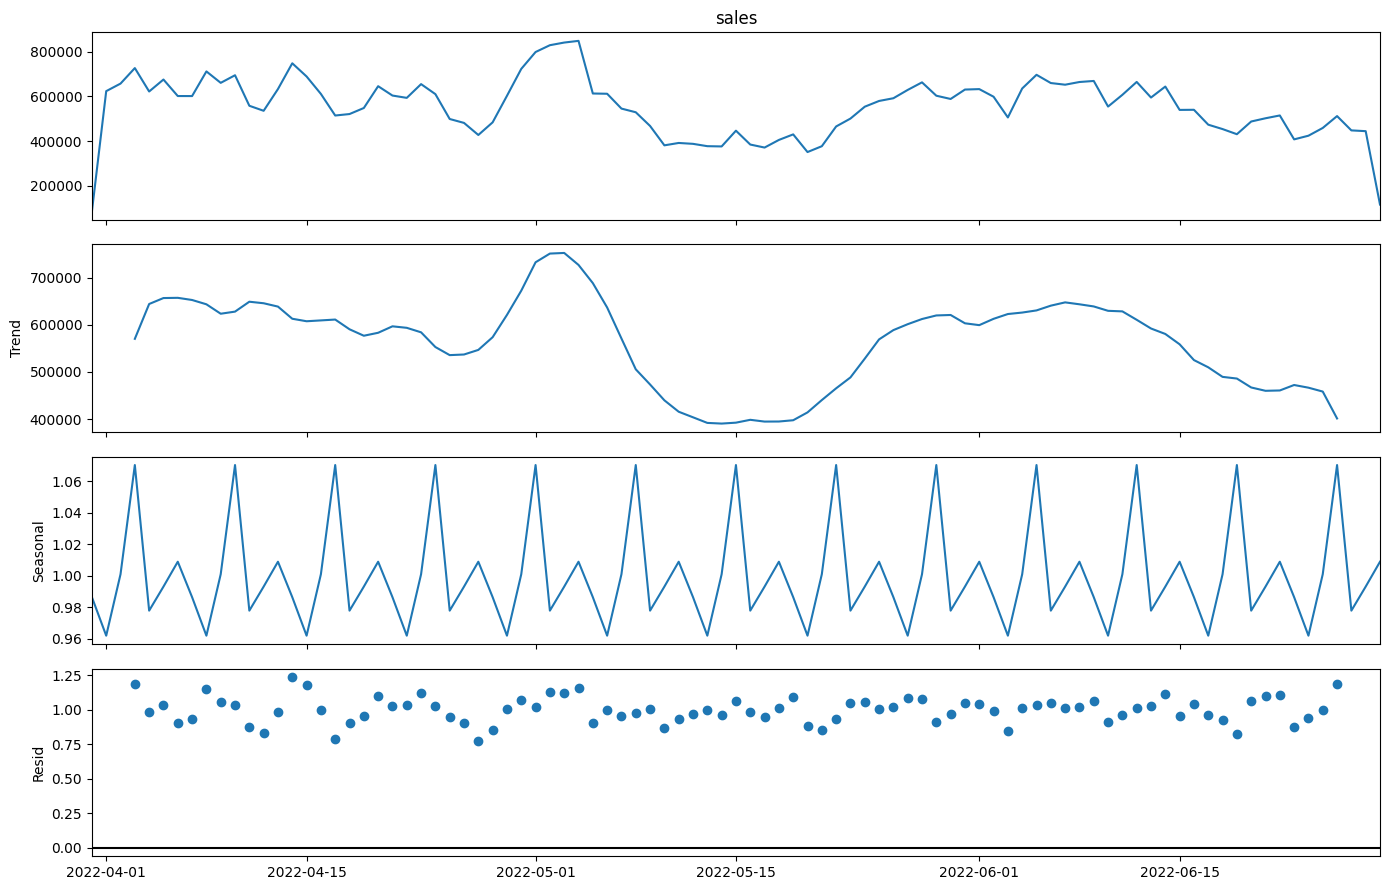

In [173]:
# Decompose the components from the time series.

pylab.rcParams['figure.figsize'] = (14, 9)
res = seasonal_decompose(df1['sales'], model='multiplicative', period=7) # interval data: harian, maka periode 365.
ax=res.plot()
plt.show()

In [174]:
res = seasonal_decompose(df1['sales'], model='multiplicative')

#Ambil index,
week = df1.index

fig = make_subplots(rows=4, cols=1, shared_xaxes=True,
                    subplot_titles=["Observed", "Trend", "Seasonal", "Residual"])

#Observed,
fig.add_trace(go.Scatter(x=week, y=res.observed, mode='lines', name='Observed'),
              row=1, col=1)

#Trend,
fig.add_trace(go.Scatter(x=week, y=res.trend, mode='lines', name='Trend'),
              row=2, col=1)

#Seasonal,
fig.add_trace(go.Scatter(x=week, y=res.seasonal, mode='lines', name='Seasonal'),
              row=3, col=1)

#Residual,
fig.add_trace(go.Scatter(x=week, y=res.resid, mode='lines', name='Residual'),
              row=4, col=1)

#Layout,
fig.update_layout(height=900, width=1000, title_text="Seasonal Decomposition (Multiplicative Model)", showlegend=False)
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Value")

fig.show()


## Splitting Data
---

In [175]:
len(df1)

91

In [176]:
# Menggunakan train:test -> 90%
train_len = int(len(df1) * 0.90)
train_len

81

In [190]:
# Splitting train dan test
train = df1[:train_len]
test = df1[train_len:]

In [178]:
# Create the figure
fig = go.Figure()

# Add traces for each DataFrame
fig.add_trace(go.Scatter(y=train['sales'], x=train.index, mode='lines', name='Train'))
fig.add_trace(go.Scatter(y=test['sales'], x=test.index, mode='lines', name='Test'))

# Update layout (optional)
fig.update_layout(title='Total Penjualan',
                  xaxis_title='Date',
                  yaxis_title='Sales')

# Show the figure
fig.show()

## Check Stationarity
---

H0: Data memiliki unit root dan data menjadi tidak stationer

H1: data tidak memiliki unit root dan data menjadi stationer

In [179]:
# Create a function to check stationarity

def check_stationarity(series):

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [180]:
check_stationarity(df1['sales'])

ADF Statistic: -3.921564
p-value: 0.001882
Critical Values:
	1%: -3.505
	5%: -2.894
	10%: -2.584
Stationary


alpha = 0.05

p-value < alpha maka H0 ditolak, berarti datanya sudah tidak memiliki unit root dan data sudah stationer. Karena data sudah stationer, maka tidak dilakukan differencing dan nilai parameter d adalah 0.

## ACF & PACF
---

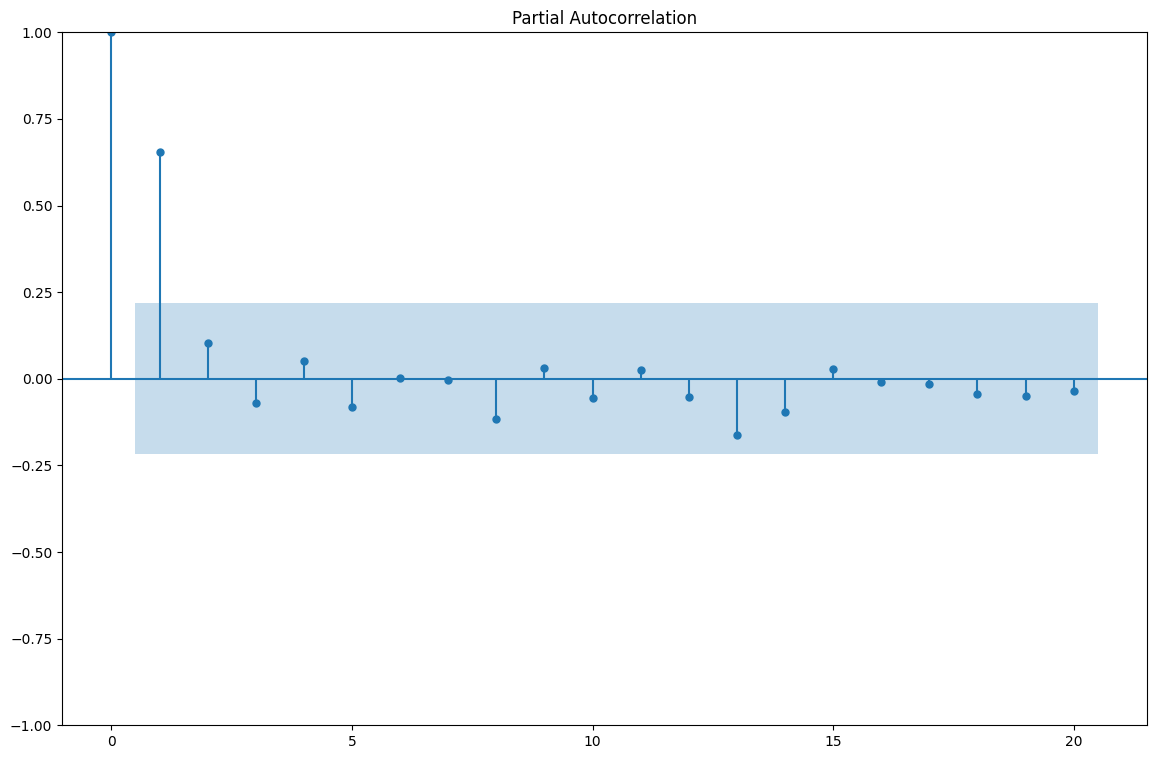

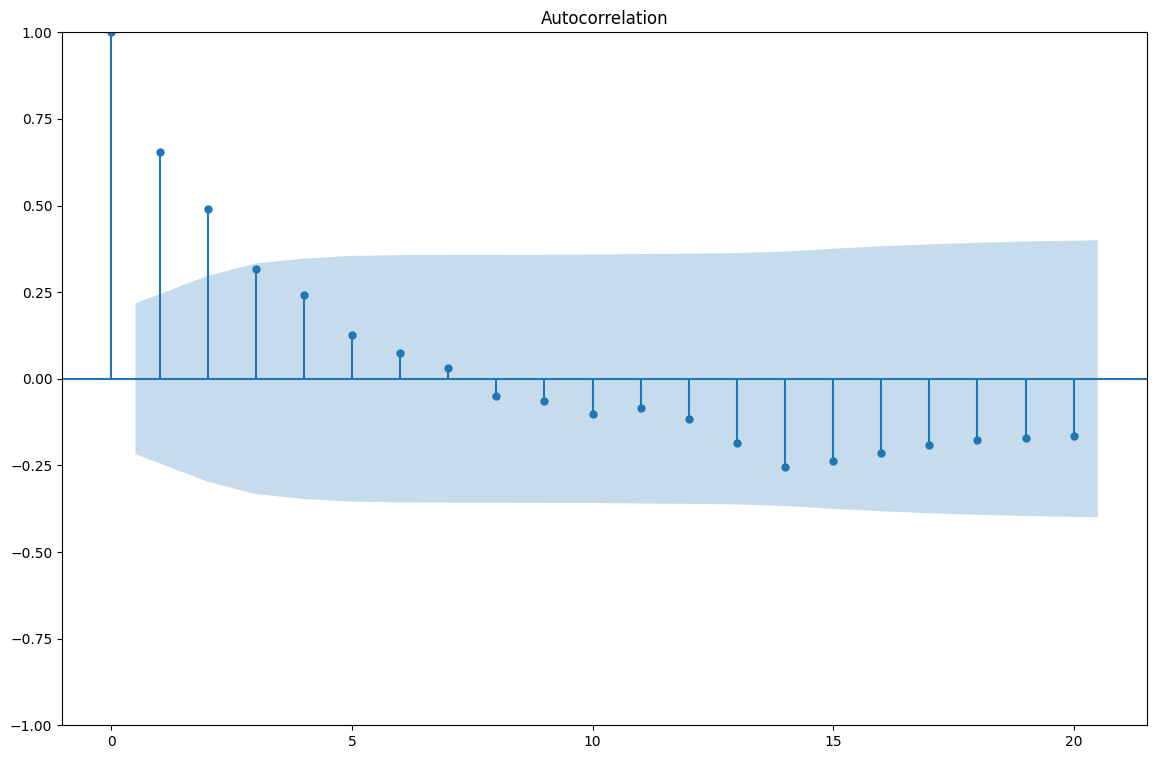

In [191]:
# Plot ACF & PACF

plot_pacf(train['sales'])
plot_acf(train['sales'])
plt.show()

Plot PACF nilai parameter p sebesar 1 dan setelahnya lag berada di confidence threshold.

Plot ACF nilai parameter q sebesar 2 dan setelahnya lag berada di confidence threshold.

Untuk differencing tidak dilakukan, maka nilai parameter d sebesar 0.

Sehingga didapat nilai p, d, q = 1, 0, 2.

## AIC
---

In [182]:
# function to get aic score, p, d, and q

def calculate_aic(data, num_p, num_d, num_q):
  # create empty df to store p, d, q, and aic score
  df1 = pd.DataFrame()

  # create empty list to store p, d, q
  pdq = [[], [], []]

  # create empty list to store aic score
  aic_score = []

  # looping to get p, d, q
  for lag_p in range(num_p + 1):
    for lag_d in range(num_d + 1):
      for lag_q in range(num_q + 1):
        # model definition
        model = ARIMA(data, order=(lag_p, lag_d, lag_q))
        # model training
        result = model.fit()
        # filling empty list with aic score which generated from model training
        aic_score.append(result.aic)
        # filling empty list with lag_p, lag_d, and lag_q
        pdq[0].append(lag_p)
        pdq[1].append(lag_d)
        pdq[2].append(lag_q)

  # value placement to dataframe
  df1['AIC'] = aic_score
  df1['p'] = pdq[0]
  df1['d'] = pdq[1]
  df1['q'] = pdq[2]

  df1.sort_values('AIC', inplace=True)
  return df1

In [183]:
# Find best model of ARIMA with combinations of p=1, d=0, q=2
calculate_aic(train['sales'], 1, 0, 2)

,AIC,p,d,q
2,2080.069494,0,0,2
3,2080.850773,1,0,0
5,2095.071992,1,0,2
4,2097.722115,1,0,1
1,2101.776345,0,0,1
0,2414.013236,0,0,0


# 4. Model Definition and Training
---

## ARIMA
---

### Model Definition
---

In [184]:
# Train ARIMA dengan kombinasi terbaik
model_arima = ARIMA(train['sales'], order=(1, 0, 2))
# 2,0,2 better
# 2,0,3 agak berbentuk, tp masih better 2,0,2 lebih ngebentuk
# 

# model training
result_arima = model_arima.fit()

print("AIC Score: ", result_arima.aic)

AIC Score:  2095.0719922484063


### Model Prediction
---

In [192]:
# Prediction Train
pred_train_ar = result_arima.predict(start=train['sales'].index[0], end=train['sales'].index[-1])
pred_train_ar = pred_train_ar.rename('predict')

pd.concat([train['sales'], pred_train_ar], axis=1)

,sales,predict
2022-03-31,84574.0,569416.259253
2022-04-01,623454.0,180038.228378
2022-04-02,657308.0,745121.555768
2022-04-03,726738.0,707938.441393
2022-04-04,621870.0,640566.717486
...,...,...
2022-06-15,539432.0,617523.341987
2022-06-16,539974.0,542169.602245
2022-06-17,473281.0,527644.641940
2022-06-18,453612.0,491105.210504


In [193]:
# Prediksi Test

pred_test_ar = result_arima.predict(start=(len(train['sales'])), end=(len(train['sales'])+len(test)-1))
pred_test_ar = pred_test_ar.rename('predict')

pred_test_ar = pd.DataFrame(pred_test_ar)
pred_test_ar.index = test.index
pred_test_ar

,predict
date,
2022-06-20,461893.632220
2022-06-21,495828.882194
2022-06-22,527568.645359
2022-06-23,545618.389855
2022-06-24,555882.904895
2022-06-25,561720.121539
2022-06-26,565039.625482
2022-06-27,566927.358473
2022-06-28,568000.873041


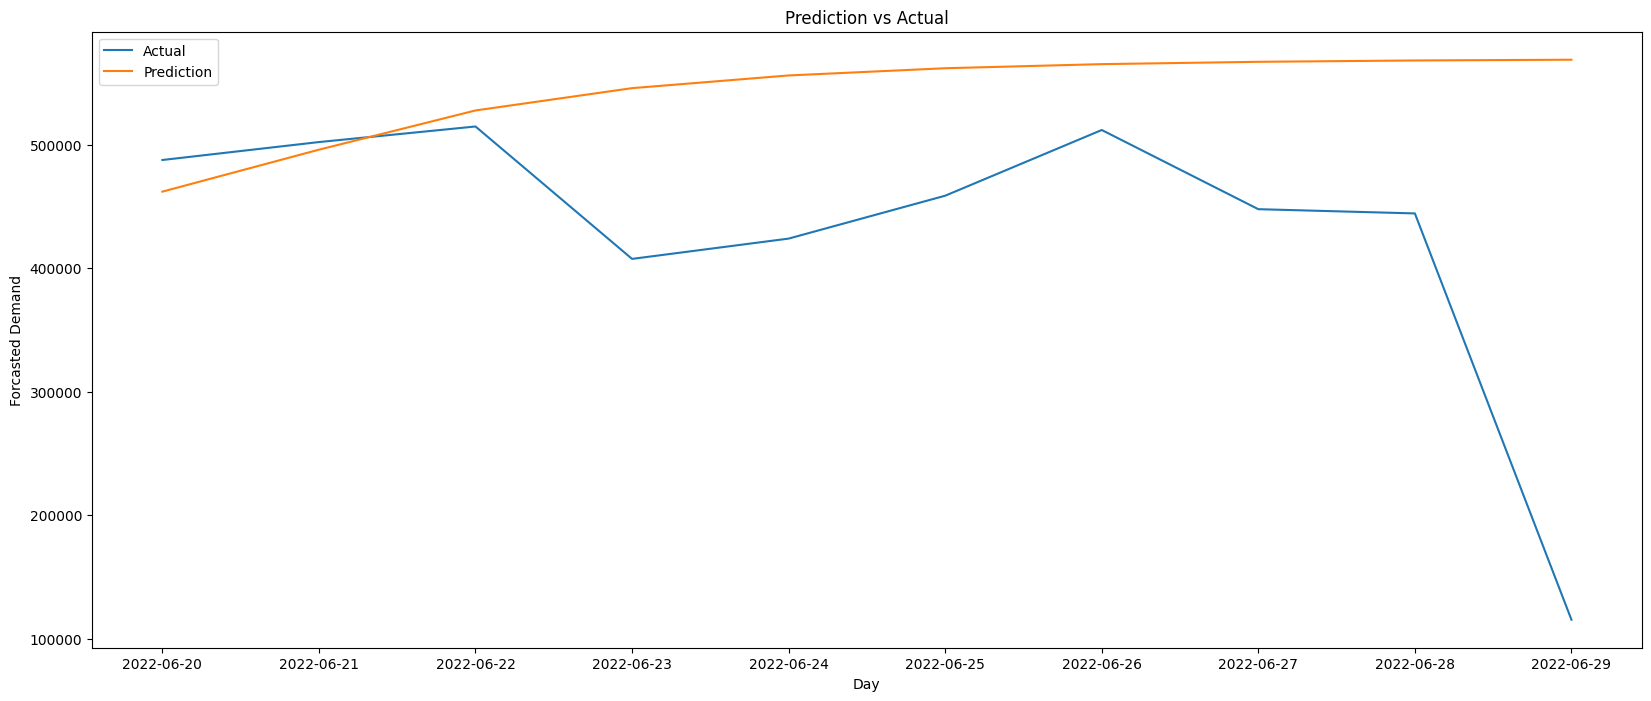

In [256]:
# plot predict test
plt.figure(figsize=(20,8))
plt.plot(test['sales'], label='Actual')
plt.plot(pred_test_ar, label='Prediction')
plt.xlabel('Day')
plt.ylabel('Forcasted Demand')
plt.title('Prediction vs Actual')
plt.legend()
plt.show()

In [195]:
# membandingkan data asli dengan prediksi

act_vs_pred_test = pd.concat([test['sales'], pred_test_ar], axis=1)
act_vs_pred_test


,sales,predict
date,,
2022-06-20,487488.0,461893.632220
2022-06-21,501999.0,495828.882194
2022-06-22,514603.0,527568.645359
2022-06-23,407495.0,545618.389855
2022-06-24,423907.0,555882.904895
2022-06-25,458603.0,561720.121539
2022-06-26,511759.0,565039.625482
2022-06-27,447699.0,566927.358473
2022-06-28,444275.0,568000.873041


### Evaluation
---

In [196]:
# Evaluation Train MAE
mae_train_ar = mean_absolute_error(train['sales'], pred_train_ar)

# Evaluation Test MAE
mae_test_ar = mean_absolute_error(test['sales'], pred_test_ar)

print(f"MAE Train : {mae_train_ar}")
print(f"MAE Test : {mae_test_ar}")

MAE Train : 63805.60379798117
MAE Test : 116719.77627245066


terlihat dari MAE dari model ARIMA Overfitting.

In [197]:
mape_train_ar = mean_absolute_percentage_error(train['sales'], pred_train_ar)

mape_test_ar = mean_absolute_percentage_error(test['sales'], pred_test_ar)

print(f"MAPE Train : {mape_train_ar}")
print(f"MAPE Test : {mape_test_ar}")

MAPE Train : 0.17305243154024727
MAPE Test : 0.5533040993940009


Dari MAPE juga terlihat model Overfitting.

## SARIMAX
---

### Model Definition
---

In [198]:
model_sarima = SARIMAX(train['sales'], order=(1,0,1), seasonal_order=(1,0,1, 7))
# 1,0,2 lumayan dr yg lain, tp masih jelek puoll
# 

result_sarima = model_sarima.fit()

print("AIC Score: ", result_sarima.aic)

AIC Score:  2101.8496018536675


In [199]:
# Train prediction
pred_train_sarima = result_sarima.predict(start=train['sales'].index[0], end=train['sales'].index[-1])
pred_train_sarima = pred_train_sarima.rename('predict')

act_vs_pred_train_sarima = pd.concat([train['sales'], pred_train_sarima], axis=1)
act_vs_pred_train_sarima

,sales,predict
2022-03-31,84574.0,0.000000
2022-04-01,623454.0,83355.421464
2022-04-02,657308.0,676213.326618
2022-04-03,726738.0,637906.620206
2022-04-04,621870.0,719400.704607
...,...,...
2022-06-15,539432.0,643398.628369
2022-06-16,539974.0,519526.159772
2022-06-17,473281.0,512803.316449
2022-06-18,453612.0,463187.027269


In [201]:
# test prediction
pred_test_sarima = result_sarima.predict(start=(len(train['sales'])), end=(len(train['sales'])+len(test)-1), dynamic=False)
pred_test_sarima = pred_test_sarima.rename('predict')

# Concate with actual test-set
act_vs_pred_test_sarima = pd.concat([test['sales'], pred_test_sarima], axis=1)
act_vs_pred_test_sarima

,sales,predict
2022-06-20,487488.0,405519.547919
2022-06-21,501999.0,410992.040369
2022-06-22,514603.0,377821.583686
2022-06-23,407495.0,369799.310658
2022-06-24,423907.0,352750.383207
2022-06-25,458603.0,340156.804388
2022-06-26,511759.0,325801.263047
2022-06-27,447699.0,317755.944682
2022-06-28,444275.0,309056.582389
2022-06-29,115595.0,302704.985320


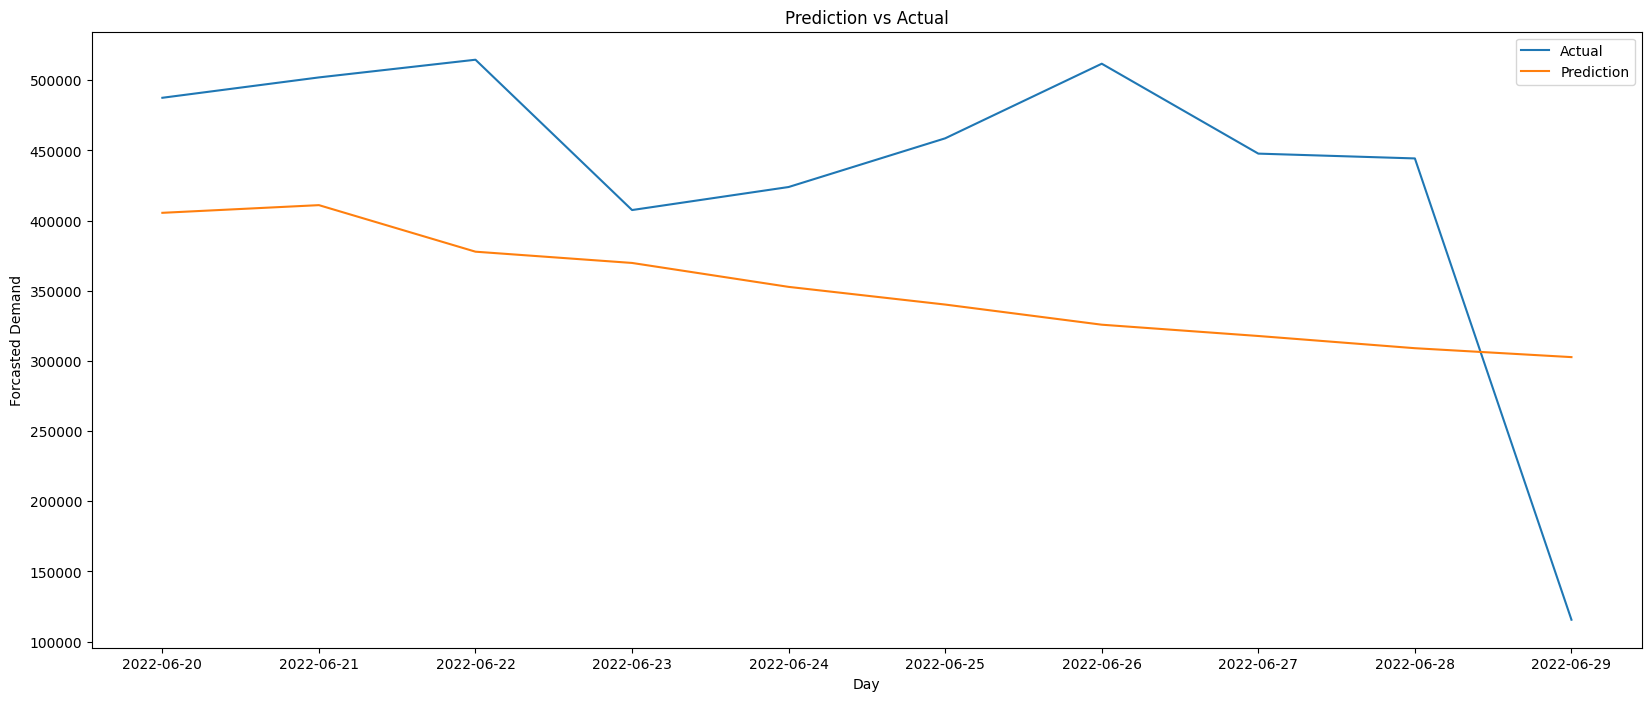

In [255]:
# plot predict test
plt.figure(figsize=(20,8))
plt.plot(test['sales'], label='Actual')
plt.plot(pred_test_sarima, label='Prediction')
plt.xlabel('Day')
plt.ylabel('Forcasted Demand')
plt.title('Prediction vs Actual')
plt.legend()
plt.show()

### Evaluation
---

In [203]:
# Evaluation Train
mae_train_sarima = mean_absolute_error(train['sales'], pred_train_sarima)

# Evaluation Test
mae_test_sarima = mean_absolute_error(test['sales'], pred_test_sarima)

print(f"MAE Train : {mae_train_sarima}")
print(f"MAE Test : {mae_test_sarima}")

MAE Train : 60469.620067056705
MAE Test : 117528.45249749286


Model Overfitting

In [204]:
# Evaluation Train
mape_train_sarima = mean_absolute_percentage_error(train['sales'], pred_train_sarima)

# Evaluation Test
mape_test_sarima = mean_absolute_percentage_error(test['sales'], pred_test_sarima)

print(f"MAPE Train : {mape_train_sarima}")
print(f"MAPE Test : {mape_test_sarima}")

MAPE Train : 0.1167505692664312
MAPE Test : 0.37105167775313935


## Holt Winters
---

In [245]:
# Copy data test
y_hat_avg = test.copy()

# Training
model_holt_win = ExponentialSmoothing(np.asarray(train['sales']) ,seasonal_periods=7 ,trend='multiplicative', seasonal='multiplicative').fit()

# result_holt_win = model_holt_win.fit()

print("AIC Score: ", model_holt_win.aic)

# Make new column
y_hat_avg['Holt_Winter'] = model_holt_win.forecast(len(test['sales']))


AIC Score:  1898.3328254855387


In [ ]:
# Train prediction
pred_train_holt = pd.Series(model_holt_win.forecast(len(train['sales'])), index= train.index)
pred_train_holt = pred_train_holt.rename('predict')

# Concate with actual train-set
act_vs_pred_train_holt = pd.concat([train['sales'], pred_train_holt], axis=1)
act_vs_pred_train_holt

,sales,predict
date,,
2022-03-31,84574.0,373406.490157
2022-04-01,623454.0,381808.277761
2022-04-02,657308.0,392927.306458
2022-04-03,726738.0,415711.020744
2022-04-04,621870.0,439924.386626
...,...,...
2022-06-15,539432.0,626006.821445
2022-06-16,539974.0,528103.958721
2022-06-17,473281.0,539986.498021


In [ ]:
# Test prediction
pred_test_holt = pd.Series(model_holt_win.forecast(len(test['sales'])), index= test.index)
pred_test_holt = pred_test_holt.rename('predict')

# Concate with actual test-set
act_vs_pred_test_holt = pd.concat([test['sales'], pred_test_holt], axis=1)
act_vs_pred_test_holt

,sales,predict
date,,
2022-06-20,487488.0,373406.490157
2022-06-21,501999.0,381808.277761
2022-06-22,514603.0,392927.306458
2022-06-23,407495.0,415711.020744
2022-06-24,423907.0,439924.386626
2022-06-25,458603.0,447020.513340
2022-06-26,511759.0,456800.675605
2022-06-27,447699.0,385360.409614
2022-06-28,444275.0,394031.164938


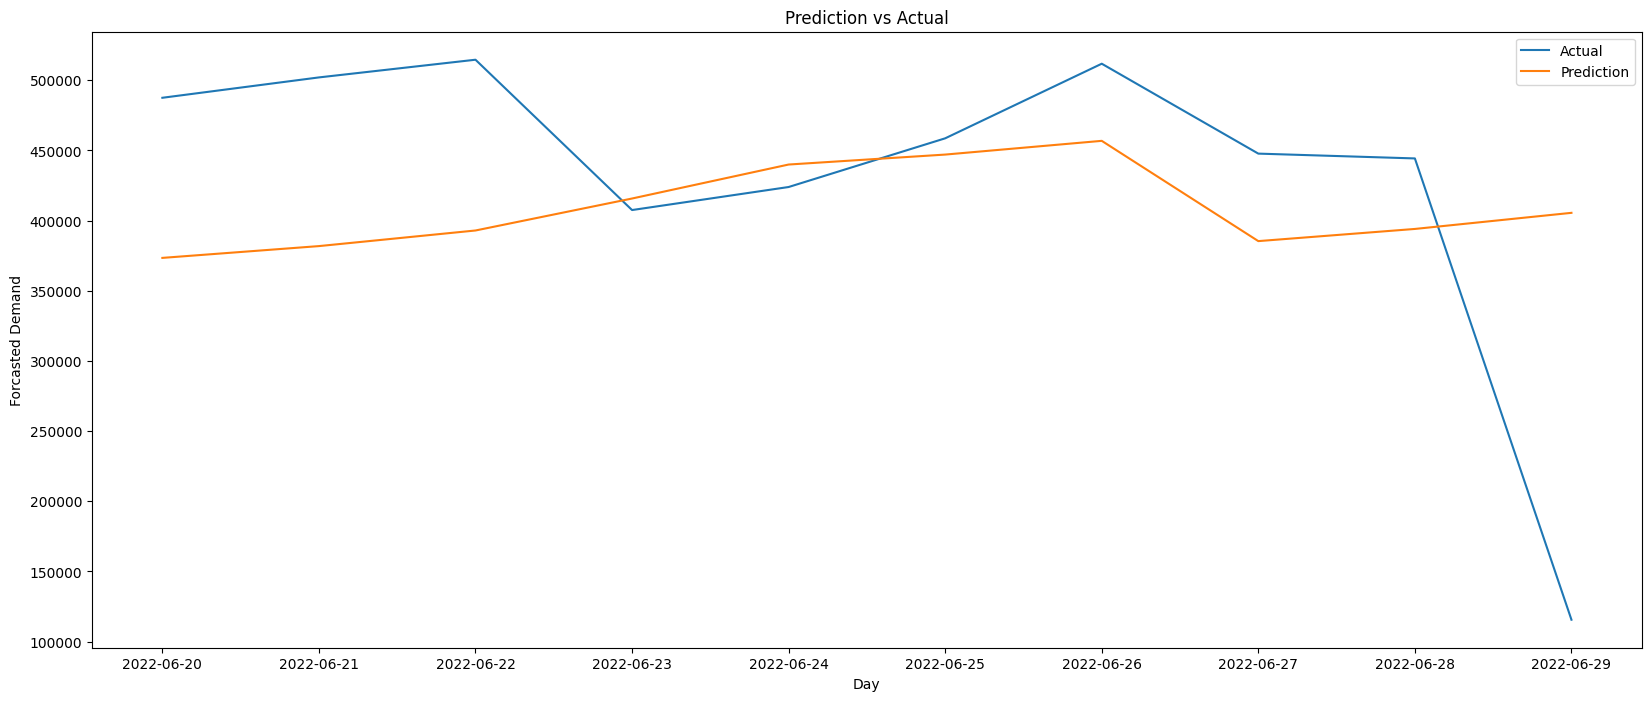

In [254]:
plt.figure(figsize=(20,8))
plt.plot(test['sales'], label='Actual')
plt.plot(pred_test_holt, label='Prediction')
plt.xlabel('Day')
plt.ylabel('Forcasted Demand')
plt.title('Prediction vs Actual')
plt.legend(loc='best')
plt.show()

### Evaluation
---

In [252]:
# Evaluation Train
mae_train_holt = mean_absolute_error(train['sales'], pred_train_holt)

# Evaluation Test
mae_test_holt = mean_absolute_error(test['sales'], pred_test_holt)

print(f"MAE Train : {mae_train_holt}")
print(f"MAE Test : {mae_test_holt}")

MAE Train : 133708.43099441862
MAE Test : 84921.57183098377


In [253]:
# Evaluation Train
mape_train_holt = mean_absolute_percentage_error(train['sales'], pred_train_holt)

# Evaluation Test
mape_test_holt = mean_absolute_percentage_error(test['sales'], pred_test_holt)

print(f"MAPE Train : {mape_train_holt}")
print(f"MAPE Test : {mape_test_holt}")

MAPE Train : 0.2617093588434368
MAPE Test : 0.3660807869211971


## SARIMAX WITH EXOGENOUS
---

In [276]:
exog_vars = train[['qty']]

model_sar_exog = SARIMAX(train['sales'], order=(0,0,1), seasonal_order=(0,0,1, 7), exog=exog_vars)

result_sar_exog = model_sar_exog.fit()

print("AIC Score: ", result_sar_exog.aic)

AIC Score:  1822.1336594426573


In [277]:
# Train prediction
pred_train_sar_exog = result_sar_exog.predict(start=train['sales'].index[0], end=train['sales'].index[-1], exog= exog_vars)
pred_train_sar_exog = pred_train_sar_exog.rename('predict')

act_vs_pred_train_sar_exog = pd.concat([train['sales'], pred_train_sar_exog], axis=1)
act_vs_pred_train_sar_exog

,sales,predict
2022-03-31,84574.0,86713.514605
2022-04-01,623454.0,624788.721734
2022-04-02,657308.0,669971.775924
2022-04-03,726738.0,710826.137439
2022-04-04,621870.0,619091.430380
...,...,...
2022-06-15,539432.0,519552.842918
2022-06-16,539974.0,537283.049056
2022-06-17,473281.0,453296.283501
2022-06-18,453612.0,453476.767594


In [278]:
exog_vars_test = test[['qty']]

# test prediction
pred_test_sar_exog = result_sar_exog.predict(start=test['sales'].index[0], end=test['sales'].index[-1], exog=exog_vars_test,  dynamic=False)
pred_test_sar_exog = pred_test_sar_exog.rename('predict')

# Concate with actual test-set
act_vs_pred_test_sar_exog = pd.concat([test['sales'], pred_test_sar_exog], axis=1)
act_vs_pred_test_sar_exog

,sales,predict
2022-06-20,487488.0,488583.803348
2022-06-21,501999.0,504845.797346
2022-06-22,514603.0,530002.727911
2022-06-23,407495.0,411521.950972
2022-06-24,423907.0,427077.237292
2022-06-25,458603.0,440320.252705
2022-06-26,511759.0,487747.052284
2022-06-27,447699.0,424030.898015
2022-06-28,444275.0,429713.639042
2022-06-29,115595.0,111121.763160


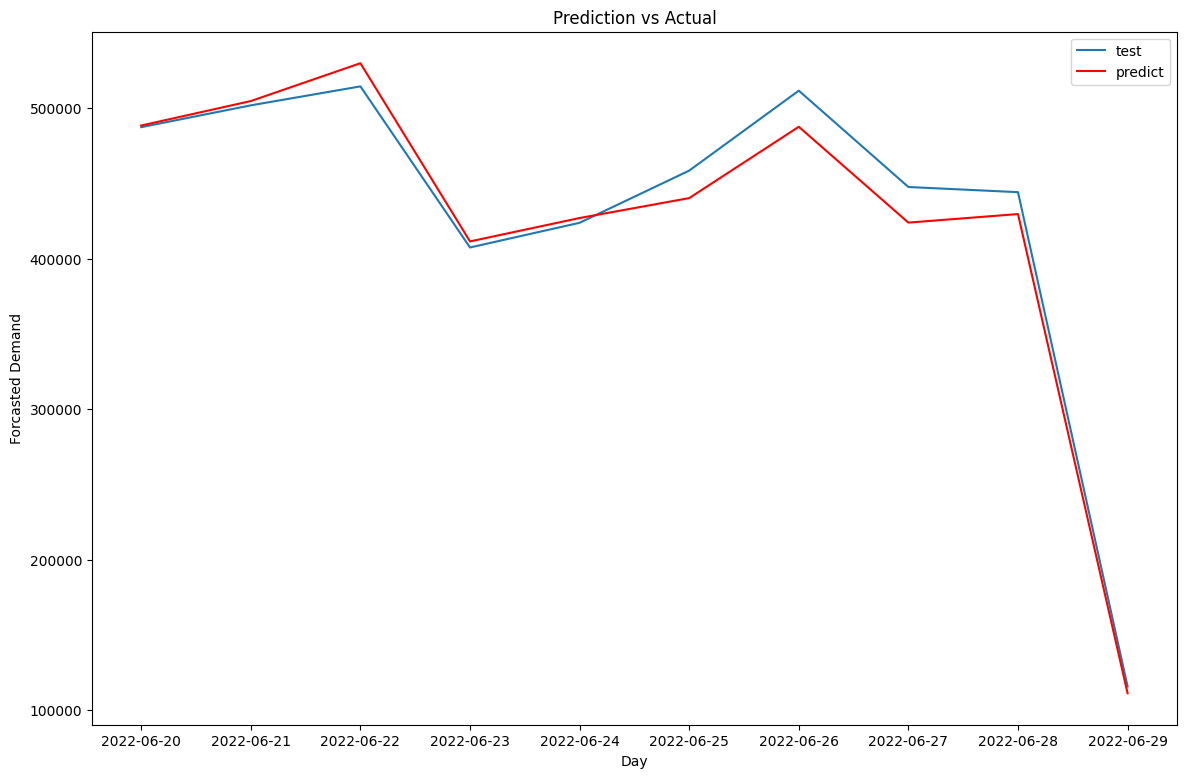

In [279]:
plt.plot(test['sales'], label = 'test')
plt.plot(pred_test_sar_exog, color = 'red', label = 'predict')
plt.xlabel('Day')
plt.ylabel('Forcasted Demand')
plt.title('Prediction vs Actual')
plt.legend()
plt.show()

### Evaluation
---

In [280]:
# Evaluation Train
mae_train_sar_exog = mean_absolute_error(train['sales'], pred_train_sar_exog)

# Evaluation Test
mae_test_sar_exog = mean_absolute_error(test['sales'], pred_test_sar_exog)

print(f"MAE Train : {mae_train_sar_exog}")
print(f"MAE Test : {mae_test_sar_exog}")

MAE Train : 13076.388731498817
MAE Test : 11153.691166244995


In [281]:
# Evaluation Train
mape_train_sar_exog = mean_absolute_percentage_error(train['sales'], pred_train_sar_exog)

# Evaluation Test
mape_test_sar_exog = mean_absolute_percentage_error(test['sales'], pred_test_sar_exog)

print(f"MAPE Train : {mape_train_sar_exog}")
print(f"MAPE Test : {mape_test_sar_exog}")

MAPE Train : 0.02336776440557518
MAPE Test : 0.026633080892998783


Jadiii BEST MODEL nya adalah SARIMAX WITH EXOGENOUS.